In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import datetime, os, shutil
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import pandas as pd
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import train_test_split
import random
import cv2
!pip install tensorflow-io==0.32.0
import tensorflow_io as tfio
from PIL import Image as Img
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
from keras import backend as K
plt.style.use("dark_background")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 21.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive

gdrive_path='/content/gdrive/MyDrive/DL_MechanoPredictor'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)

Mounted at /content/gdrive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


Get the directories of the elastographies and the masks.

In [4]:
image_dir = './Elastography_images_full/b_mode_rect/'
i=0
for f in os.listdir(image_dir):
  if f.endswith('.tif'):
    i+=1
print(i)

1908


In [5]:
image_dir = './Elastography_images_full/b_mode_rect_mask/'
i=0
for f in os.listdir(image_dir):
  if f.endswith('.png'):
    i+=1
print(i)

1908


In [6]:
image_dir = './Elastography_images_full/b_mode_rect/'
mask_dir = './Elastography_images_full/b_mode_rect_mask/'

input_img_paths = sorted(
    [
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
        if fname.endswith(".tif")
    ]
)
mask_img_paths = sorted(
    [
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of images:", len(input_img_paths))
print("Number of masks:", len(mask_img_paths))

for input_path, target_path in zip(input_img_paths[-20:], mask_img_paths[-20:]):
    print(input_path, "|", target_path)

# NOTE: In Google drive, it might be not in alphabetical order but with this the images are sorted correctly in the two folders

Number of images: 1908
Number of masks: 1908
./Elastography_images_full/b_mode_rect/MCA_TRANILASTDOSE_DAY18C5_1D_b.tif | ./Elastography_images_full/b_mode_rect_mask/MCA_TRANILASTDOSE_DAY18C5_1D_b__mask.png
./Elastography_images_full/b_mode_rect/MCA_TRANILASTDOSE_DAY18C6_1D.tif | ./Elastography_images_full/b_mode_rect_mask/MCA_TRANILASTDOSE_DAY18C6_1D__mask.png
./Elastography_images_full/b_mode_rect/MCA_TRANILASTDOSE_DAY18C6_1D_b.tif | ./Elastography_images_full/b_mode_rect_mask/MCA_TRANILASTDOSE_DAY18C6_1D_b__mask.png
./Elastography_images_full/b_mode_rect/MCA_TRANILASTDOSE_DAY18C6_1D_c.tif | ./Elastography_images_full/b_mode_rect_mask/MCA_TRANILASTDOSE_DAY18C6_1D_c__mask.png
./Elastography_images_full/b_mode_rect/MCA_TRANILASTDOSE_DAY18C6_NONE.tif | ./Elastography_images_full/b_mode_rect_mask/MCA_TRANILASTDOSE_DAY18C6_NONE__mask.png
./Elastography_images_full/b_mode_rect/MCA_TRANILASTDOSE_DAY18C6_NONE_b.tif | ./Elastography_images_full/b_mode_rect_mask/MCA_TRANILASTDOSE_DAY18C6_NONE_b

# Segmentation Pipeline

The model will take as input the whole image and first crop the b-mode.
From the b_mode, the model will then segment the tumor.

In [ ]:
img_mask = cv2.imread(mask_img_paths[0])
img_mask.shape

(285, 530, 3)

Text(0.5, 1.0, 'Mask')

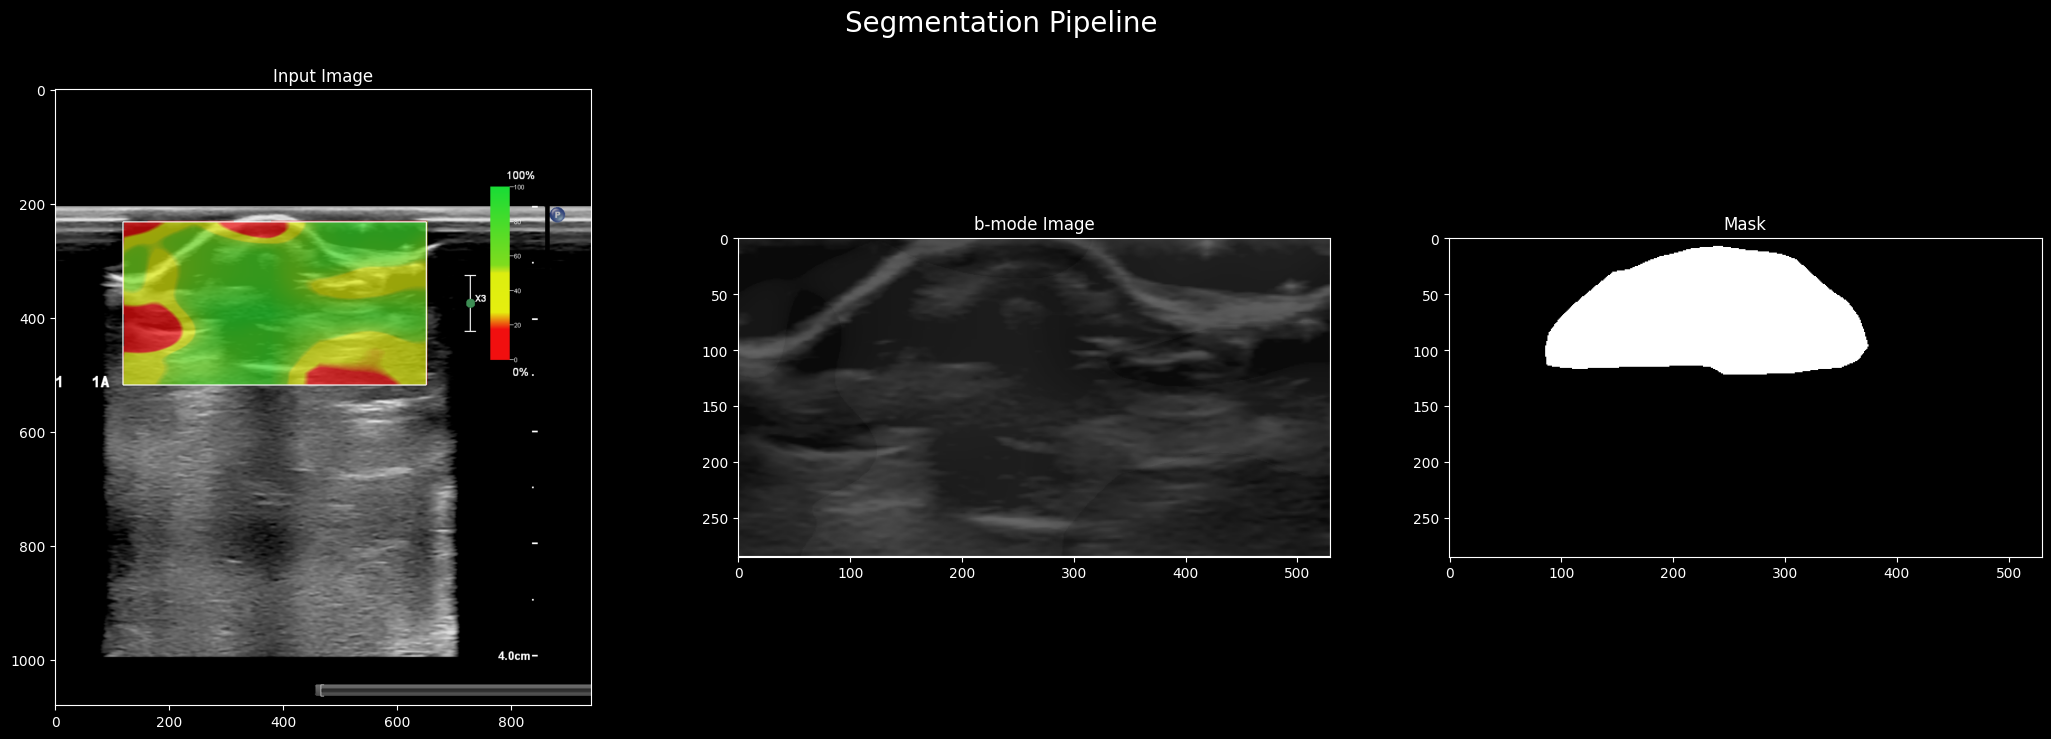

In [ ]:
directory=input_img_paths[0].replace('_rect', '')
img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(26,8))
plt.suptitle("Segmentation Pipeline", fontsize=20)
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")

img = cv2.cvtColor(cv2.imread(input_img_paths[0]),cv2.COLOR_BGR2RGB)
plt.subplot(1,3,2)
plt.imshow(img)
plt.title("b-mode Image")

img_mask = cv2.cvtColor(cv2.imread(mask_img_paths[0]),cv2.COLOR_BGR2RGB)
plt.subplot(1,3,3)
plt.imshow(img_mask)
plt.title("Mask")

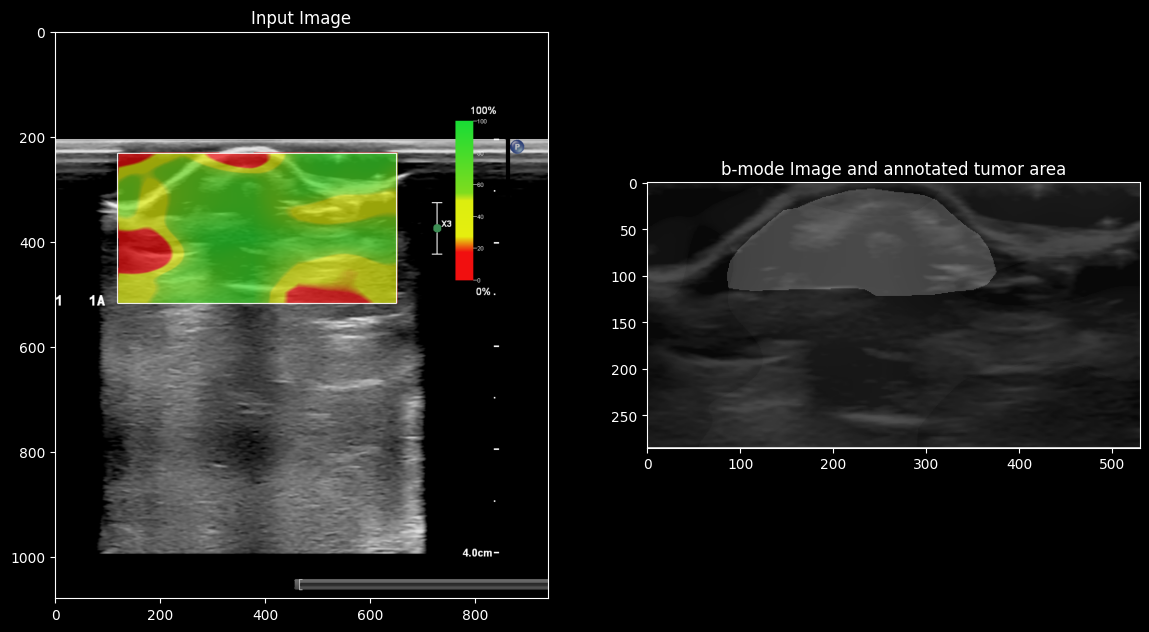

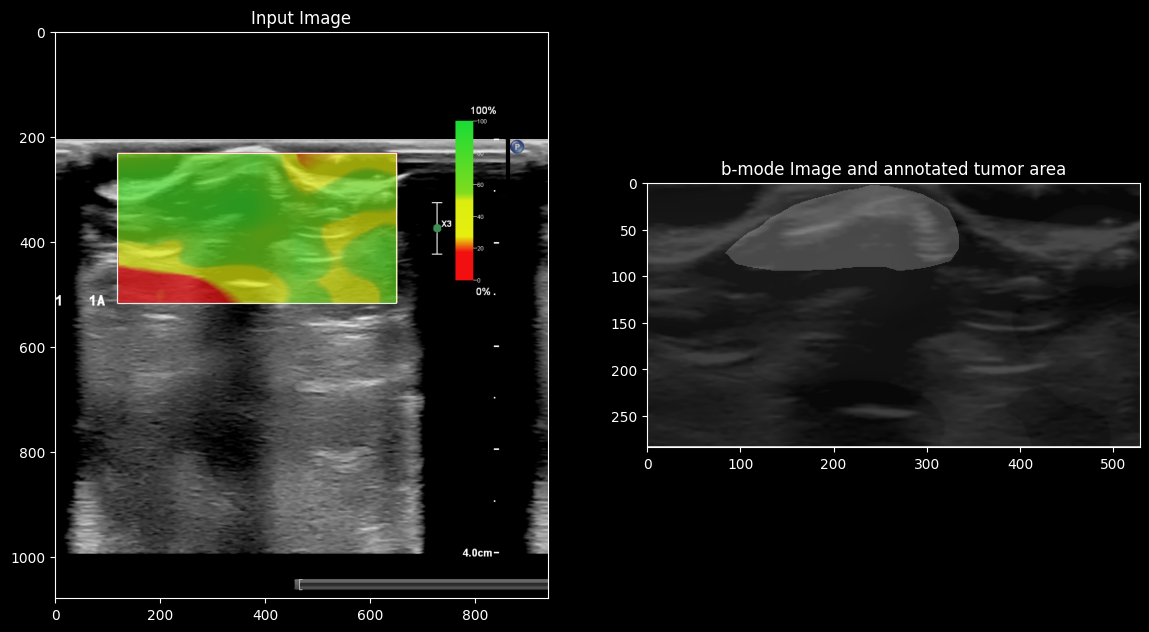

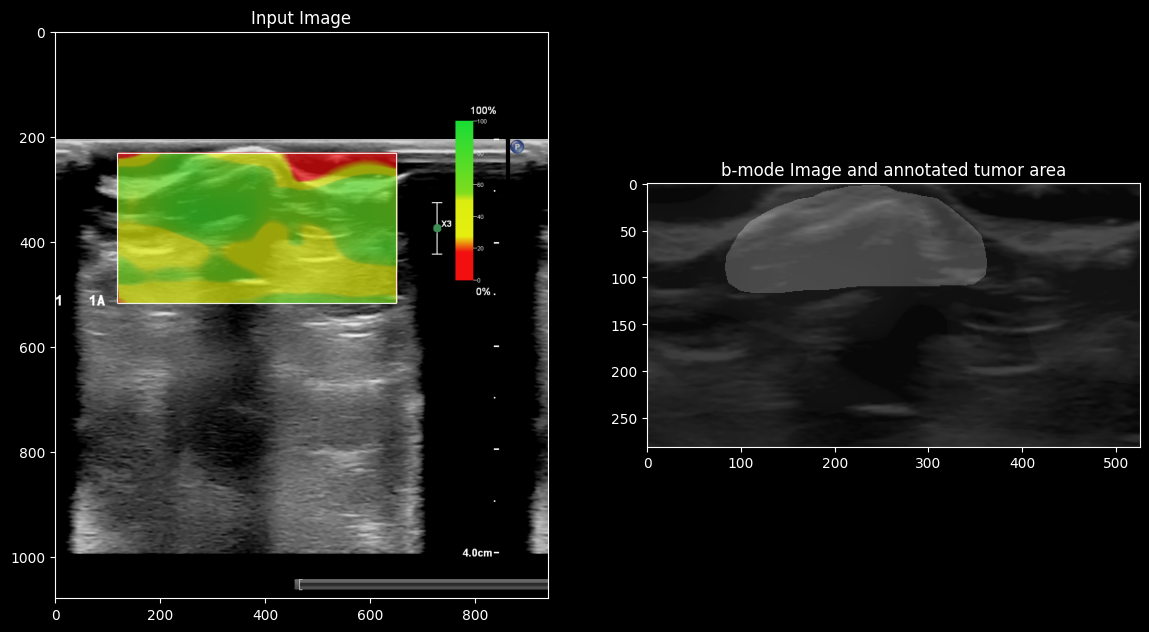

In [7]:
for i in range(3):
  directory=input_img_paths[i].replace('_rect', '')
  img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(14,8))
  # plt.suptitle("Segmentation Pipeline", fontsize=20)
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title("Input Image")

  img = cv2.cvtColor(cv2.imread(input_img_paths[i]),cv2.COLOR_BGR2RGB)
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.title("b-mode Image and annotated tumor area")

  mask=cv2.cvtColor(cv2.imread(mask_img_paths[i]),cv2.COLOR_BGR2RGB)
  plt.subplot(1,2,2)
  plt.imshow(mask,cmap='Greys', alpha=0.2)

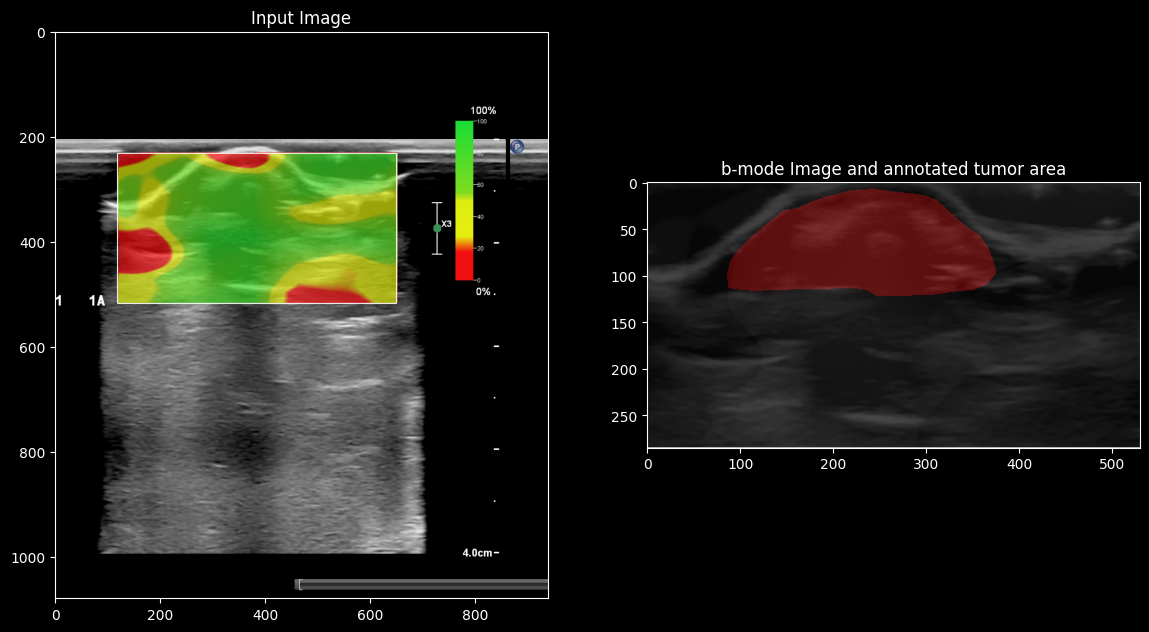

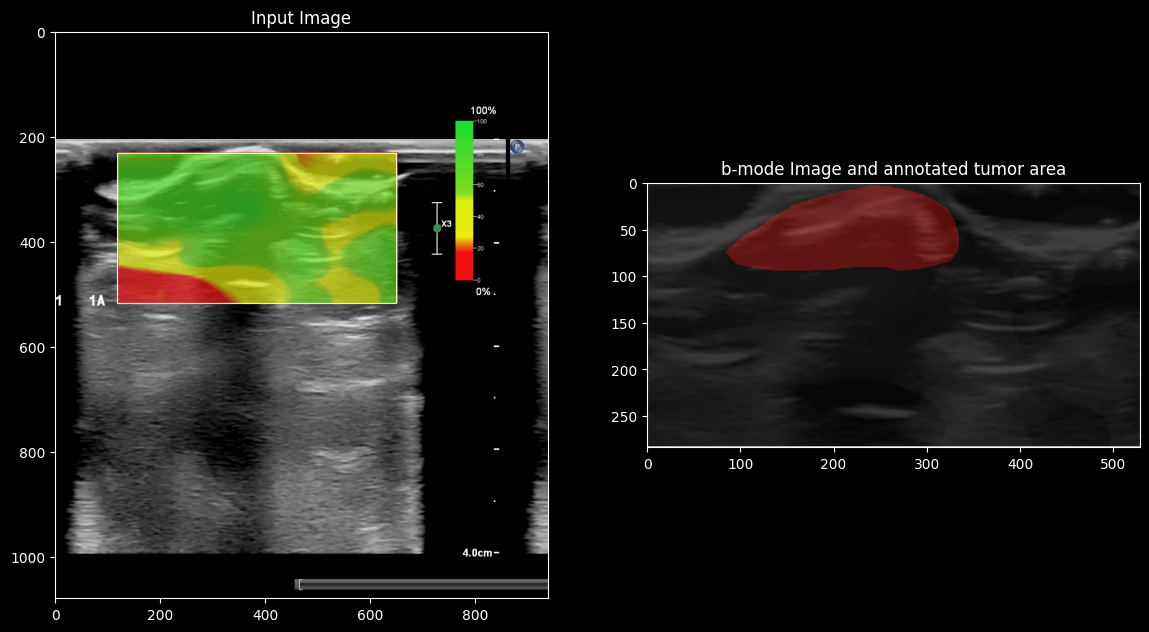

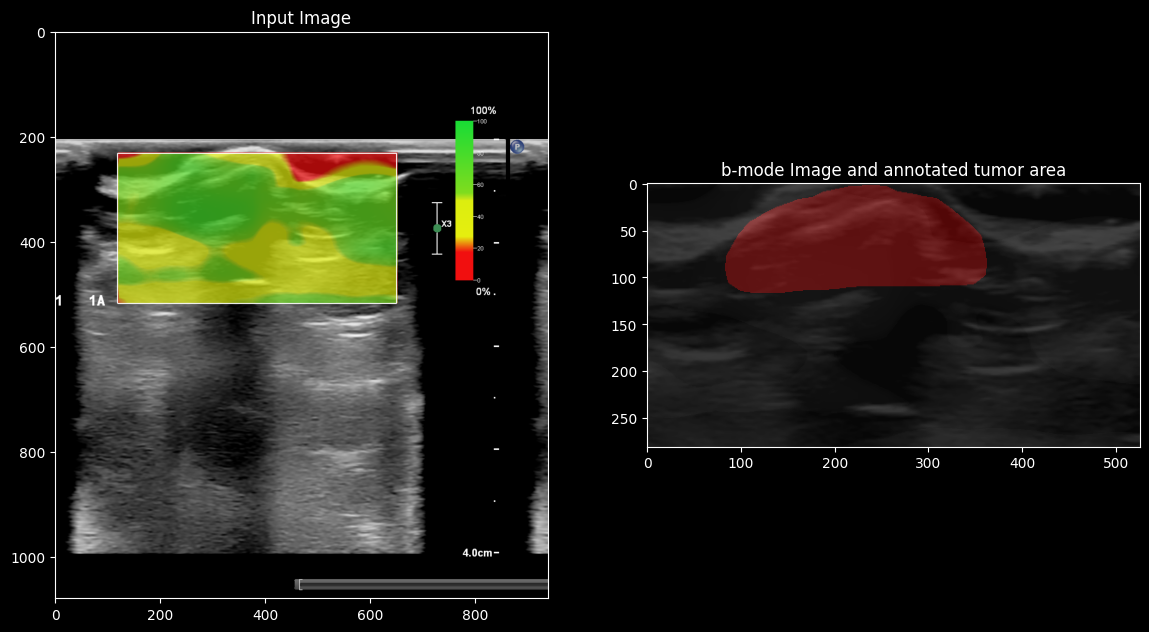

In [8]:
for i in range(3):
  directory=input_img_paths[i].replace('_rect', '')
  img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(14,8))
  # plt.suptitle("Segmentation Pipeline", fontsize=20)
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title("Input Image")

  img = cv2.cvtColor(cv2.imread(input_img_paths[i]),cv2.COLOR_BGR2RGB)
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.title("b-mode Image and annotated tumor area")

  mask=cv2.cvtColor(cv2.imread(mask_img_paths[i]),cv2.COLOR_BGR2RGB)
  mask[:,:,1]=0
  mask[:,:,2]=0
  plt.subplot(1,2,2)
  plt.imshow(mask,cmap='gray', alpha=0.3)

## Split Dataset
Here we split our dataset in train and test.

In [10]:
# shuffle the paths and prepare train-test split
train_split=int(len(input_img_paths)*0.7)
val_split=int(len(input_img_paths)*0.85)
input_img_paths, mask_img_paths = shuffle(input_img_paths, mask_img_paths, random_state=14)
input_img_paths_train, mask_img_paths_train = input_img_paths[: train_split], mask_img_paths[: train_split]
input_img_paths_val, mask_img_paths_val = input_img_paths[train_split:val_split], mask_img_paths[train_split:val_split]
input_img_paths_test, mask_img_paths_test = input_img_paths[val_split:], mask_img_paths[val_split:]

print(f"Training set: {len(input_img_paths_train)} \nValidation set: {len(input_img_paths_val)} \nTest set: {len(input_img_paths_test)}")

Training set: 1335 
Validation set: 286 
Test set: 287


# Create train and test datasets

In [11]:
IMG_SHAPE = (64,64)
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

def scale_down(image, mask):
  # apply scaling to image and mask
  image = tf.cast(image, tf.float32) / 255.0
  mask = tf.cast(mask,tf.float32) / 255.0
  return image, mask


def load_and_preprocess(img_filepath, mask_filepath):
   # load the image and resize it
    img = tf.io.read_file(img_filepath)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.resize(img, [IMG_SHAPE[0], IMG_SHAPE[1]])
    img = tf.reshape(img,[IMG_SHAPE[0], IMG_SHAPE[1],4])
    img= tfio.experimental.color.rgba_to_rgb(img)

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE[0], IMG_SHAPE[1]])

    img, mask = scale_down(img, mask)

    print(img.shape)
    print(mask.shape)
    return img, mask


trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, mask_img_paths_train))
validloader = tf.data.Dataset.from_tensor_slices((input_img_paths_val, mask_img_paths_val))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, mask_img_paths_test))


trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validloader = (
    validloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

(64, 64, 3)
(64, 64, 1)
(64, 64, 3)
(64, 64, 1)
(64, 64, 3)
(64, 64, 1)


In [ ]:
for i, (images, labels) in enumerate(trainloader.take(1)):
  print(labels.shape)

(32, 64, 64, 1)


In [ ]:
print(f"Number of batches in the train dataset is {len(trainloader)}.")
print(f"Number of batches in the val dataset is {len(validloader)}.")
print(f"Number of batches in the test dataset is {len(testloader)}.")

Number of batches in the train dataset is 42.
Number of batches in the val dataset is 9.
Number of batches in the test dataset is 9.


## U-net like architecture model trained using b-mode images.

In [ ]:
inputs = keras.Input(shape=(64, 64,3))

# Encoder
x = layers.Conv2D(1, 3, padding="same")(inputs)
x = layers.Activation("relu")(x)

conv1 = layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(x)
pool1 = layers.MaxPooling2D(pool_size=(2,2))(conv1)
bn1   = layers.BatchNormalization()(pool1)
drop1 = layers.Dropout(0.5)(bn1)

conv2 = layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(drop1)
pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv2)
bn2   = layers.BatchNormalization()(pool2)
drop2 = layers.Dropout(0.5)(bn2)

conv3 = layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(drop2)
pool3 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
bn3   = layers.BatchNormalization()(pool3)
drop3 = layers.Dropout(0.5)(bn3)

conv4 = layers.Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(drop3)
pool4 = layers.MaxPooling2D(pool_size=(2,2))(conv4)
bn4   = layers.BatchNormalization()(pool4)
drop4 = layers.Dropout(0.5)(bn4)

# Bottleneck
conv14 = layers.Conv2D(1028, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop4)
bn14   = layers.BatchNormalization()(conv14)
drop14 = layers.Dropout(0.5)(bn14)

up5 = layers.UpSampling2D(size=(2, 2))(drop14)
merge5 = layers.concatenate([conv4,up5], axis=3)
conv5 = layers.Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge5)
bn5   = layers.BatchNormalization()(conv5)
drop5 = layers.Dropout(0.5)(bn5)

# Decoder
up6 = layers.UpSampling2D(size=(2, 2))(drop5)
merge6 = layers.concatenate([conv3,up6], axis=3)
conv6 = layers.Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
bn6   = layers.BatchNormalization()(conv6)
drop6 = layers.Dropout(0.5)(bn6)

up7 = layers.UpSampling2D(size=(2, 2))(drop6)
merge7 = layers.concatenate([conv2,up7], axis=3)
conv7 = layers.Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
bn7   = layers.BatchNormalization()(conv7)
drop7 = layers.Dropout(0.5)(bn7)

up8 = layers.UpSampling2D(size=(2, 2))(drop7)
merge8 = layers.concatenate([conv1,up8], axis=3)
conv8 = layers.Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
bn8   = layers.BatchNormalization()(conv8)
drop8 = layers.Dropout(0.5)(bn8)

# Add a per-pixel classification layer
outputs = layers.Conv2D(2, 3, activation="softmax", padding="same")(drop8)

# Define the model
model = keras.Model(inputs, outputs)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 1)    28          ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 64, 64, 1)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   640         ['activation[0][0]']             
                                                                                              

In [ ]:
epochs = 400
lr=0.001

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(lr, epochs)

# Compile the model
adam=keras.optimizers.Adam(learning_rate=lr)

def lr_scheduler(epoch, lr):
    return cosine_decay(epoch)

lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

model.compile(optimizer=adam, loss="sparse_categorical_crossentropy",metrics=tf.keras.metrics.MeanIoU(num_classes=2,sparse_y_pred=False))

early_stop=tf.keras.callbacks.EarlyStopping(monitor="val_mean_io_u", min_delta=0,patience=60,verbose=0, mode="max",baseline=None,restore_best_weights=True,start_from_epoch=15)

# Train the model, doing validation at the end of each epoch.

with tf.device('/device:GPU:0'):
  history=model.fit(trainloader, epochs=300,validation_data=validloader, callbacks=[early_stop,lr_scheduler_callback])

Epoch 1/300
42/42 [==============================] - 9s 45ms/step - loss: 0.5510 - mean_io_u: 0.5686 - val_loss: 1.1314 - val_mean_io_u: 0.3862 - lr: 0.0010
Epoch 2/300
42/42 [==============================] - 2s 37ms/step - loss: 0.2982 - mean_io_u: 0.6780 - val_loss: 1.7416 - val_mean_io_u: 0.3818 - lr: 9.9998e-04
Epoch 3/300
42/42 [==============================] - 2s 38ms/step - loss: 0.2521 - mean_io_u: 0.6972 - val_loss: 1.4651 - val_mean_io_u: 0.3869 - lr: 9.9994e-04
Epoch 4/300
42/42 [==============================] - 2s 37ms/step - loss: 0.2292 - mean_io_u: 0.7179 - val_loss: 1.8578 - val_mean_io_u: 0.3709 - lr: 9.9986e-04
Epoch 5/300
42/42 [==============================] - 2s 37ms/step - loss: 0.2158 - mean_io_u: 0.7319 - val_loss: 2.4175 - val_mean_io_u: 0.3591 - lr: 9.9975e-04
Epoch 6/300
42/42 [==============================] - 2s 37ms/step - loss: 0.2138 - mean_io_u: 0.7309 - val_loss: 1.7589 - val_mean_io_u: 0.3804 - lr: 9.9961e-04
Epoch 7/300
42/42 [===================

9/9 [==============================] - 90s 8s/step - loss: 0.2555 - mean_io_u: 0.8037

Test loss: 0.25547412037849426 
Test MeanIoU: 0.8036643266677856

9/9 [==============================] - 1s 100ms/step


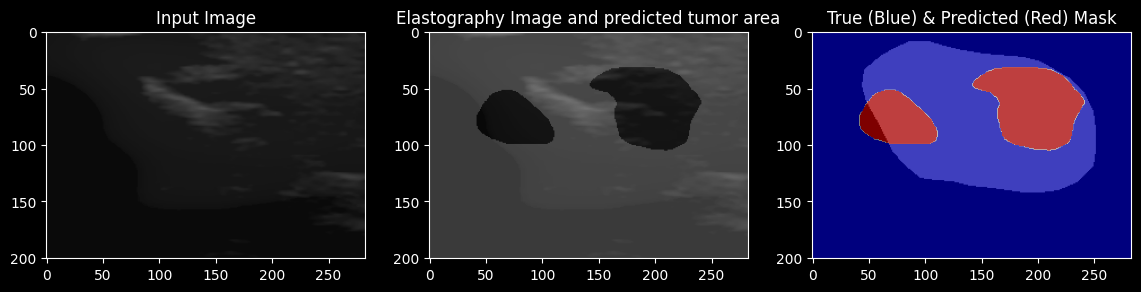

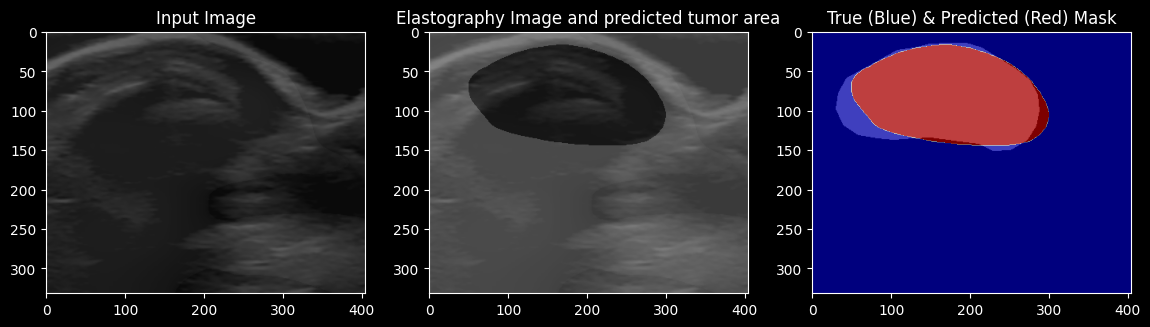

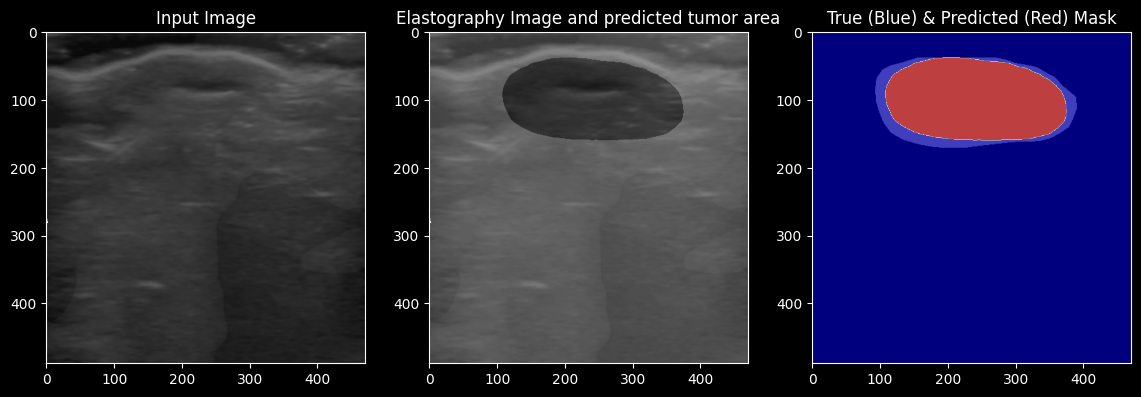

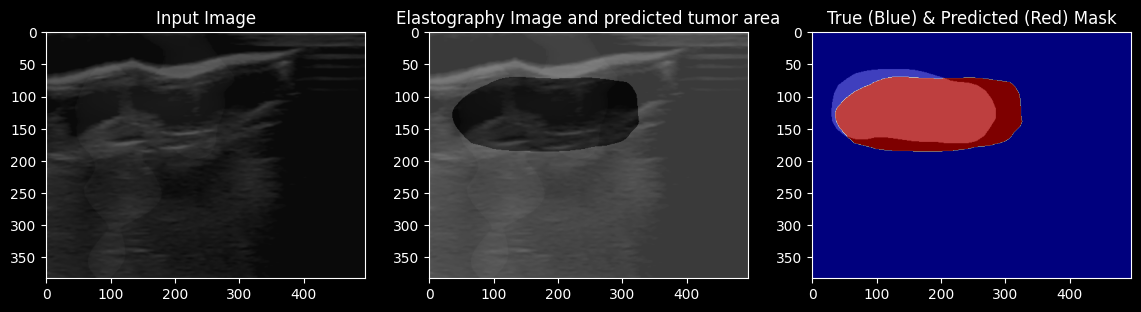

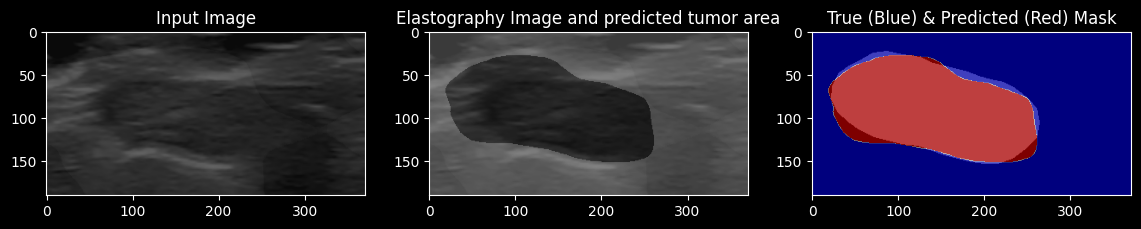

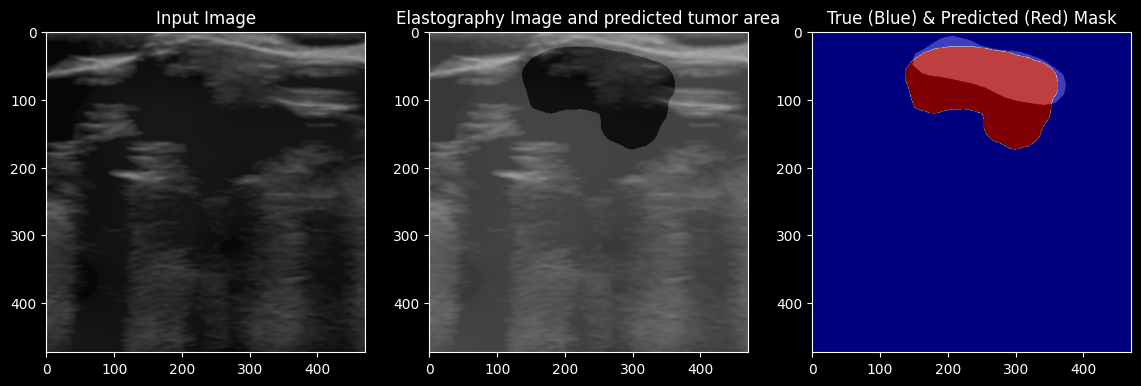

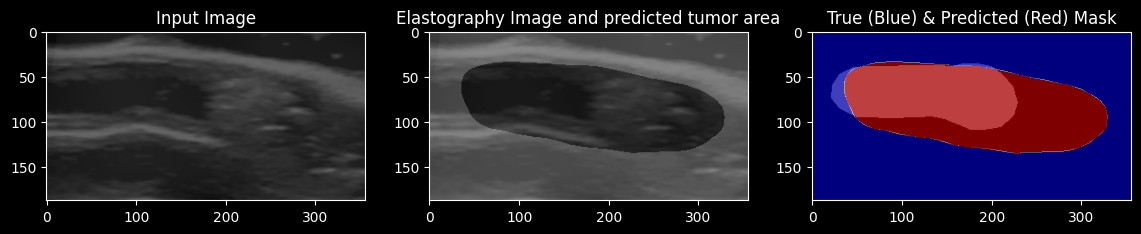

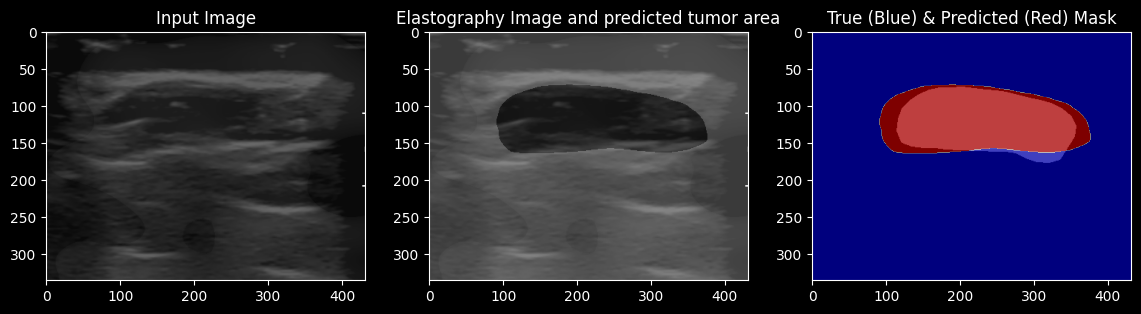

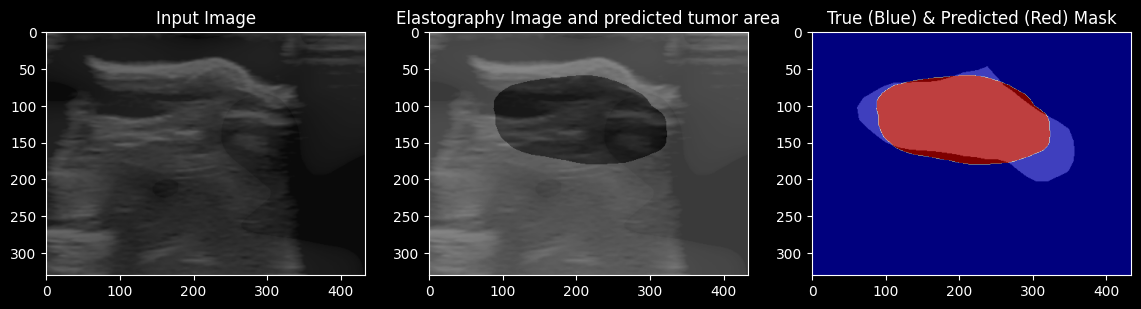

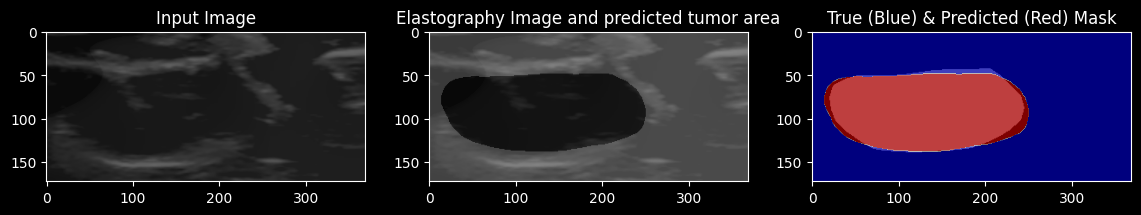

In [13]:
loss,iou = model.evaluate(testloader)
print(f"\nTest loss: {loss} \nTest MeanIoU: {iou}\n")
predictions= model.predict(testloader)

#Display true mask and predictions
for i in range(10):
  directory=input_img_paths_test[i].replace('images_elastography', 'images')
  img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(14,8))
  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.title("Input Image")

  img = cv2.cvtColor(cv2.imread(input_img_paths_test[i]),cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,2)
  plt.imshow(img)
  plt.title("Elastography Image and predicted tumor area")

  mask=tf.image.resize(predictions[i],[img.shape[0],img.shape[1]])
  mask = np.argmax(mask, axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img3 = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  plt.subplot(1,3,2)
  plt.imshow(img3,cmap='Greys', alpha=0.2)

  img_mask = ImageOps.autocontrast(load_img(mask_img_paths_test[i]))
  plt.subplot(1,3,3)
  plt.imshow(img_mask,cmap='Greys',alpha=0.5)
  plt.title("True (Blue) & Predicted (Red) Mask")

  mask=tf.image.resize(predictions[i],[img.shape[0],img.shape[1]])
  mask = np.argmax(mask, axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img3 = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  plt.subplot(1,3,3)
  plt.imshow(img3,cmap='bwr', alpha=0.5)

In [12]:
# save the model
# model.save("model_bmode_segm")
model = keras.models.load_model('model_bmode_segm')

In [ ]:
np.save('segmentation_bmode_model_history.npy',history.history)

In [ ]:
df=np.load('segmentation_bmode_model_history.npy',allow_pickle=True)
df1=pd.DataFrame({'lr': df.item()['lr'],'loss': df.item()['loss'],'mean_iou': df.item()['mean_io_u'],'val_loss': df.item()['val_loss'],'val_mean_iou': df.item()['val_mean_io_u']})
print(df1.head())

      lr      loss  mean_iou  val_loss  val_mean_iou
0  0.001  0.550953  0.568572  1.131403      0.386175
1  0.001  0.298248  0.677989  1.741600      0.381842
2  0.001  0.252054  0.697167  1.465068      0.386877
3  0.001  0.229201  0.717938  1.857821      0.370906
4  0.001  0.215842  0.731935  2.417529      0.359100


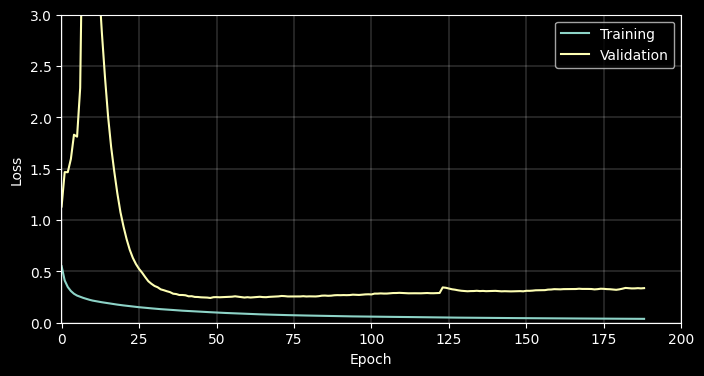

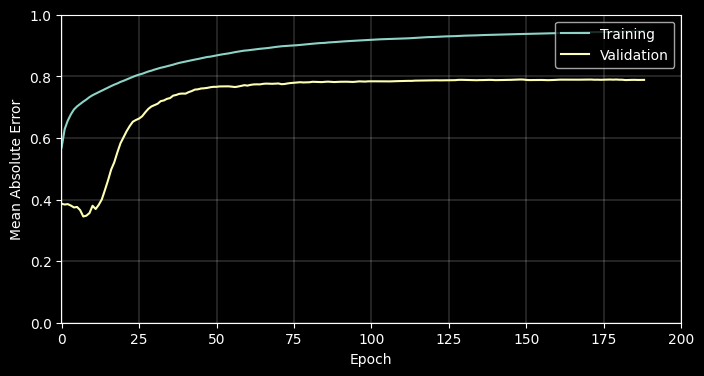

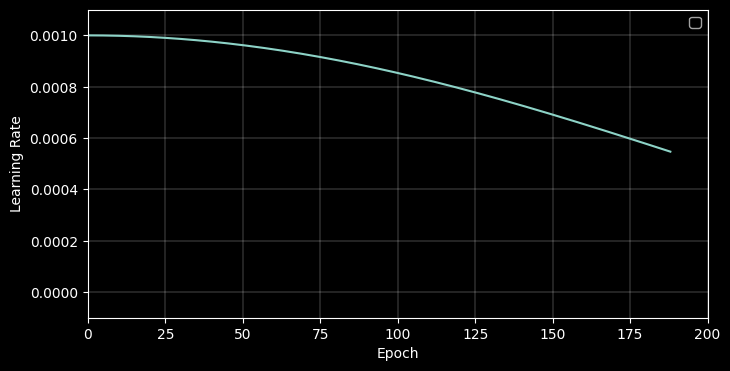

In [ ]:
plt.figure(figsize=(8,4))
ax = df1['loss'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_loss'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.grid(linewidth=0.2)
plt.ylim([0, 3])
plt.xlim([-0.1, 200])
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
ax = df1['mean_iou'].ewm(span=10).mean().plot(label='Training')
ax = df1['val_mean_iou'].ewm(span=10).mean().plot(label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
plt.grid(linewidth=0.2)
plt.ylim([0, 1])
plt.xlim([-0.1, 200])
plt.legend(loc='upper right')

plt.figure(figsize=(8,4))
ax = df1['lr'].plot(label='')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
plt.grid(linewidth=0.2)
plt.ylim([-0.0001,0.0011])
plt.xlim([-0.1, 200])
plt.legend(loc='upper right')

probability:  1
probability:  9
probability: 15
probability: 19


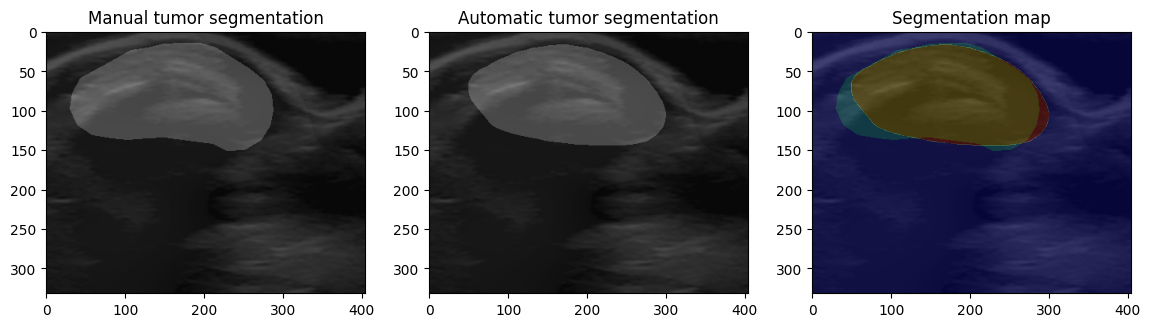

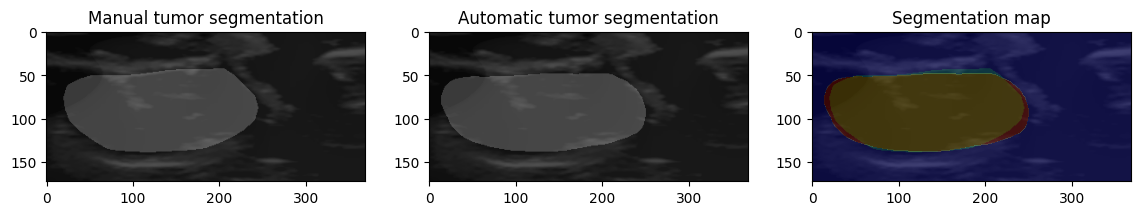

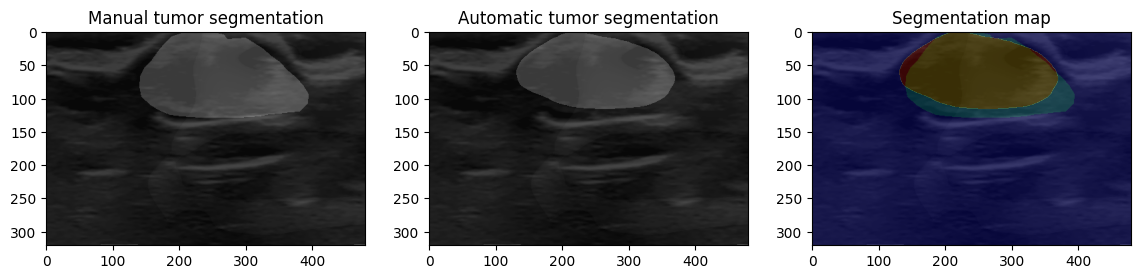

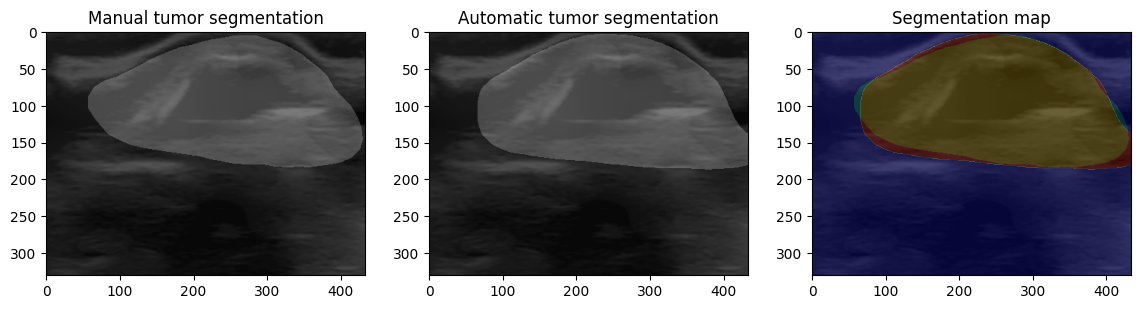

In [ ]:
plt.style.use("default")

j=1
for i in [1,9,15,19]:
  x=f'example: %2.f' %j
  directory=input_img_paths_test[i].replace('images_elastography', 'images')
  img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(14,8))

  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.title("Manual tumor segmentation")
  plt.subplot(1,3,1)
  mask = cv2.cvtColor(cv2.imread(mask_img_paths_test[i]),cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='Greys', alpha=0.2)

  plt.subplot(1,3,2)
  # img = cv2.cvtColor(cv2.imread(input_img_paths_test[i]),cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,2)
  plt.imshow(img)
  plt.title("Automatic tumor segmentation")

  mask=tf.image.resize(predictions[i],[img.shape[0],img.shape[1]])
  mask = np.argmax(mask, axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img3 = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  plt.subplot(1,3,2)
  plt.imshow(img3,cmap='Greys_r', alpha=0.2)


  plt.subplot(1,3,3)
  img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title("Segmentation map")
  plt.subplot(1,3,3)
  mask = cv2.cvtColor(cv2.imread(mask_img_paths_test[i]),cv2.COLOR_BGR2RGB)
  mask[:,:,0]=0
  mask[:,:,2]=0
  plt.imshow(mask,cmap='Greys', alpha=0.2)

  mask=tf.image.resize(predictions[i],[img.shape[0],img.shape[1]])
  mask=np.array(mask)

  mask = np.argmax(mask, axis=-1)
  mask = np.expand_dims(mask, axis=-1)

  plt.subplot(1,3,3)
  plt.imshow(mask,cmap='bwr', alpha=0.2)
  j+=1

#### Trim the predicted segmentation

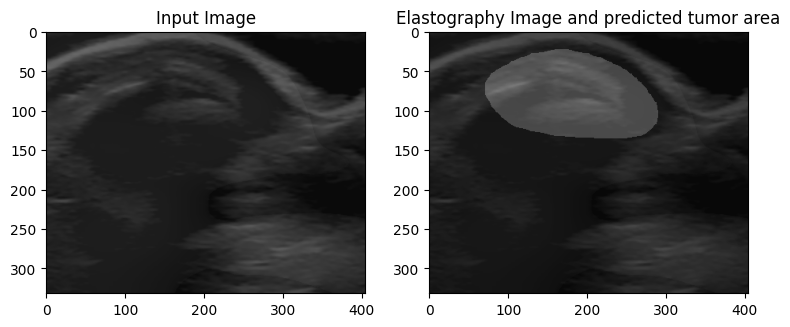

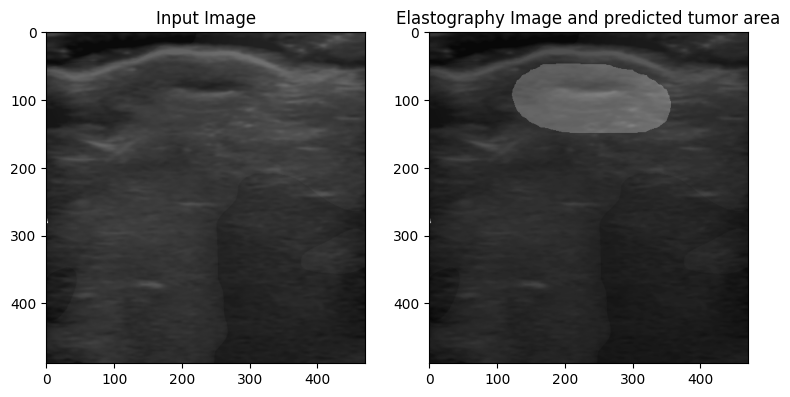

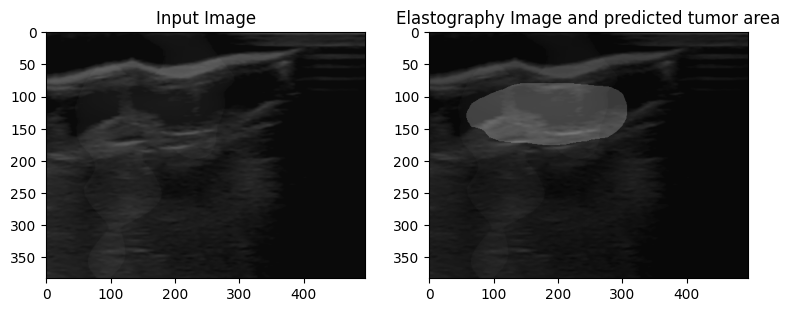

In [19]:
#Display true mask and predictions
for i in range(1,4):
  directory=input_img_paths_test[i].replace('images_elastography', 'images')
  img = cv2.cvtColor(cv2.imread(directory),cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(14,8))
  # plt.suptitle("Segmentation Pipeline", fontsize=20)
  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.title("Input Image")

  img = cv2.cvtColor(cv2.imread(input_img_paths_test[i]),cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,2)
  plt.imshow(img)
  plt.title("Elastography Image and predicted tumor area")

  mask=tf.image.resize(predictions[i],[img.shape[0],img.shape[1]])
  first_channel = mask[..., 0]

  # Expand dimensions to add a new axis at the end
  expanded_tensor = tf.expand_dims(first_channel, -1)
  expanded_tensor.shape
  expanded_tensor[0][0]
  x=np.where(expanded_tensor[:][:][:]>0.05,0,1)
  x.shape
  y=tf.Variable(expanded_tensor)
  y=y.numpy()
  y[:][:][:]=x
  mask=tf.constant(y)
  plt.subplot(1,3,2)
  plt.imshow(mask,cmap='Greys_r', alpha=0.2)


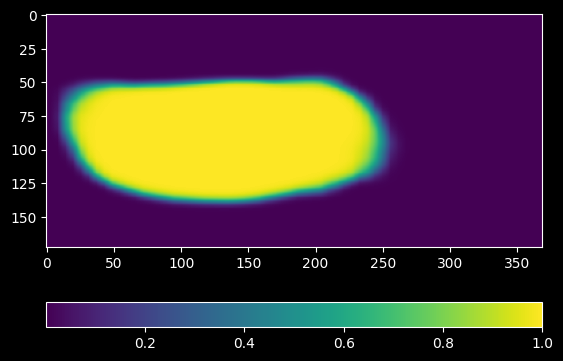

In [ ]:
plt.imshow(1-expanded_tensor,cmap='viridis')
plt.colorbar( orientation='horizontal')